In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold



In [2]:
# Parameter
train_dir = "D:/kuliah/Tugas Akhir/Code/Klasifikasi Jenis Buah Lokal/dataset/rgb_dataset/train"
validation_dir = "D:/kuliah/Tugas Akhir/Code/Klasifikasi Jenis Buah Lokal/dataset/rgb_dataset/val"
test_dir = "D:/kuliah/Tugas Akhir/Code/Klasifikasi Jenis Buah Lokal/dataset/test" 
k = 3  # Jumlah fold untuk K-FCV
epochs = 50  # Jumlah epoch untuk training model per fold
batch_size = 64  # Batch size

# Image size
IMG_SIZE = (300, 300)


In [3]:
# Import data
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 2403 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [4]:
def get_batch(generator, index):
    data = []
    labels = []
    for i in index:
        x, y = generator[i]
        data.extend(x)
        labels.extend(y)
    return np.array(data), np.array(labels)

In [5]:
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.5),
        Dense(16, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    
    return model

model = create_model()
print(model.summary())

<ipython-input-5-ca7b5d164f6f>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

None


In [6]:
def plot_history(history_list, k):
    fig, axs = plt.subplots(nrows=k, ncols=2, figsize=(12, k * 4))

    for i, history in enumerate(history_list):
        # Plot Accuracy
        axs[i, 0].plot(history['accuracy'], label=f'Train Fold {i+1}')
        axs[i, 0].plot(history['val_accuracy'], label=f'Validation Fold {i+1}')
        axs[i, 0].set_title(f'Fold {i+1} - Training and Validation Accuracy')
        axs[i, 0].set_xlabel('Epochs')
        axs[i, 0].set_ylabel('Accuracy')
        axs[i, 0].legend()

        # Plot Loss
        axs[i, 1].plot(history['loss'], label=f'Train Fold {i+1}')
        axs[i, 1].plot(history['val_loss'], label=f'Validation Fold {i+1}')
        axs[i, 1].set_title(f'Fold {i+1} - Training and Validation Loss')
        axs[i, 1].set_xlabel('Epochs')
        axs[i, 1].set_ylabel('Loss')
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

<ipython-input-5-ca7b5d164f6f>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.6740 - loss: 0.8600 - precision_1: 0.7549 - recall_1: 0.6215 - val_accuracy: 0.9531 - val_loss: 0.1411 - val_precision_1: 0.9574 - val_recall_1: 0.9447
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.9046 - loss: 0.1654 - precision_1: 0.9416 - recall_1: 0.8791 - val_accuracy: 0.9880 - val_loss: 0.0400 - val_precision_1: 0.9879 - val_recall_1: 0.9844
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.9023 - loss: 0.1664 - precision_1: 0.9585 - recall_1: 0.8678 - val_accuracy: 0.9760 - val_loss: 0.0707 - val_precision_1: 0.9807 - val_recall_1: 0.9748
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.9000 - loss: 0.1392 - precision_1: 0.9577 - recall_1: 0.8842 - val_accuracy: 0.9315 - val_loss: 0.1731 - val_precision_1: 0.9378 - val_recall_1: 0.9243
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.8910 - loss: 0.1509 - precision_1: 0.9617 - recall_1: 0.8656 - val_

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 729ms/step - accuracy: 1.0000 - loss: 1.9012e-05 - precision_1: 1.0000 - recall_1: 1.0000
Fold 1 - Validation Accuracy: 1.0
Fold 1 - Validation Loss: 6.598053005291149e-05


c:\Users\CATUR WARGA COMPUTER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 1.0000 - loss: 7.9123e-05 - precision_1: 1.0000 - recall_1: 1.0000
Fold 1 - Test Accuracy: 1.0
Fold 1 - Test Loss: 0.00014970439951866865
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.7224 - loss: 0.8557 - precision_2: 0.7660 - recall_2: 0.6394 - val_accuracy: 0.9564 - val_loss: 0.1088 - val_precision_2: 0.9561 - val_recall_2: 0.9502
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.9606 - loss: 0.1158 - precision_2: 0.9746 - recall_2: 0.9477 - val_accuracy: 0.9577 - val_loss: 0.1354 - val_precision_2: 0.9577 - val_recall_2: 0.9577
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.9750 - loss: 0.0646 - precision_2: 0.9853 - recall_2: 0.9646 - val_accuracy: 0.9689 - val_loss: 0.0791 - val_precision_2: 0.9689 - val_recall_2: 0.9689
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.9699 - loss: 0.0665 - precision_2: 0.9825 - recall_2: 0.9600 - val_accuracy: 0.9801 - val_loss: 0.

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 705ms/step - accuracy: 1.0000 - loss: 2.5521e-07 - precision_2: 1.0000 - recall_2: 1.0000
Fold 2 - Validation Accuracy: 1.0
Fold 2 - Validation Loss: 1.9089856095888535e-07
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9777 - loss: 0.1583 - precision_2: 0.9777 - recall_2: 0.9777
Fold 2 - Test Accuracy: 0.9800000190734863
Fold 2 - Test Loss: 0.14096218347549438
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.6939 - loss: 0.8650 - precision_3: 0.7462 - recall_3: 0.6093 - val_accuracy: 0.9089 - val_loss: 0.2540 - val_precision_3: 0.9100 - val_recall_3: 0.9089
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.9451 - loss: 0.1079 - precision_3: 0.9700 - recall_3: 0.9332 - val_accuracy: 0.9701 - val_loss: 0.1124 - val_precision_3: 0.9700 - val_recall_3: 0.9674
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.9630 - loss: 0.0653 - precision_3: 0.9791 - recall_3: 0.9558 - val_accuracy: 0.9570 - val_loss: 0.1937 

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 733ms/step - accuracy: 0.9607 - loss: 0.2577 - precision_3: 0.9620 - recall_3: 0.9589
Fold 3 - Validation Accuracy: 0.9466145634651184
Fold 3 - Validation Loss: 0.3481062948703766
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7842 - loss: 3.2848 - precision_3: 0.7922 - recall_3: 0.7816
Fold 3 - Test Accuracy: 0.7433333396911621
Fold 3 - Test Loss: 4.124449253082275

Average Validation Accuracy: 0.9822048544883728
Average Validation Loss: 0.11605748876633015

Average Test Accuracy: 0.9077777862548828


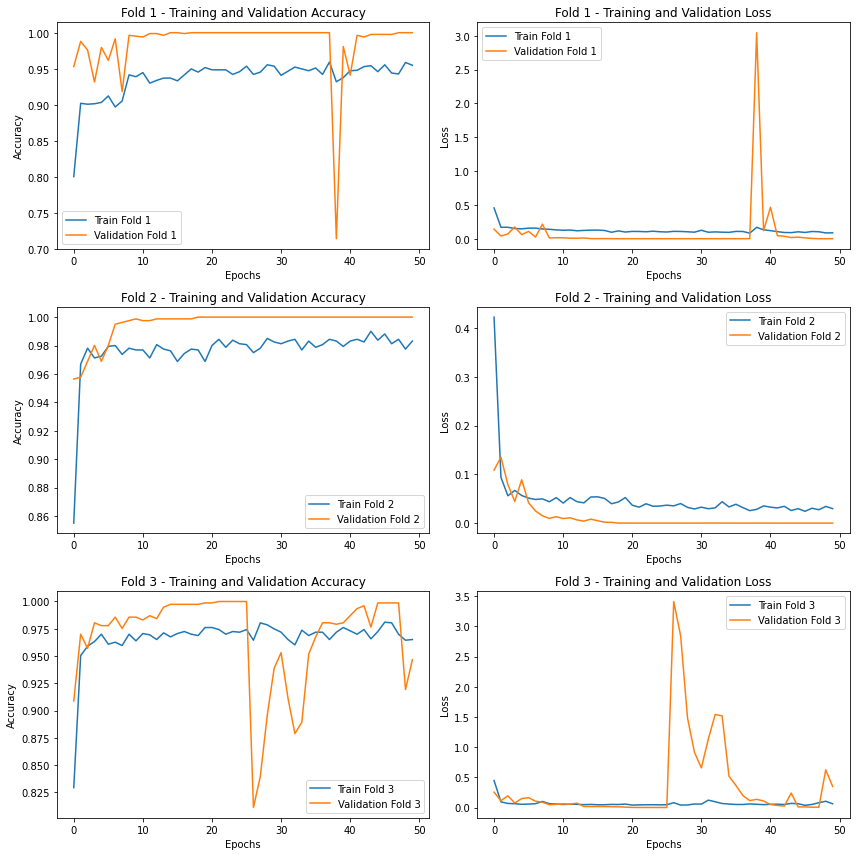

In [7]:
# Evaluasi dengan K-FCV
history_list = []
average_acc = 0
average_loss = 0

kf = KFold(n_splits=k, shuffle=True, random_state=42)

# List to store accuracy and loss for each fold
fold_accuracy = []
fold_loss = []
test_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(train_generator)):
    # Dapatkan batch data pelatihan dan validasi berdasarkan indeks fold
    train_data, train_labels = get_batch(train_generator, train_index)
    val_data, val_labels = get_batch(train_generator, val_index)

    # Buat model baru untuk setiap fold
    model = create_model()

    # Latih model menggunakan data pelatihan
    history = model.fit(
        train_data,
        train_labels,
        epochs=epochs,
        validation_data=(val_data, val_labels),
        verbose=1,  # Tampilkan informasi training per epoch
    )

    history_list.append(history.history)

    # Save the model for each fold
    model.save(f"D:/kuliah/Tugas Akhir/Code/Klasifikasi Jenis Buah Lokal/models/K-Fold Validation/MobileNetV2-RGB_fold_{fold+1}.h5")
    

    # Evaluate the model using the validation data
    val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_data, val_labels)
    fold_accuracy.append(val_accuracy)
    fold_loss.append(val_loss)

    print(f"Fold {fold+1} - Validation Accuracy: {val_accuracy}")
    print(f"Fold {fold+1} - Validation Loss: {val_loss}")

    # Evaluate the model using the test data
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
    test_accuracies.append(test_accuracy)
    print(f"Fold {fold+1} - Test Accuracy: {test_accuracy}")
    print(f"Fold {fold+1} - Test Loss: {test_loss}")

# Calculate average accuracy and loss across all folds
average_acc = np.mean(fold_accuracy)
average_loss = np.mean(fold_loss)
average_test_accuracy = np.mean(test_accuracies)

print(f"\nAverage Validation Accuracy: {average_acc}")
print(f"Average Validation Loss: {average_loss}")
print(f"\nAverage Test Accuracy: {average_test_accuracy}")

# Plotting hasil training dan validasi untuk setiap fold
plot_history(history_list, k)


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
Fold 1 Results:
TP: 100
FN: 0
TN: 100
FP: 0
Accuracy: 1.0



5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Fold 2 Results:
TP: 94
FN: 6
TN: 100
FP: 0
Accuracy: 0.97



4/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000238F306FB80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Fold 3 Results:
TP: 26
FN: 62
TN: 100
FP: 0
Accuracy: 0.6702127659574468



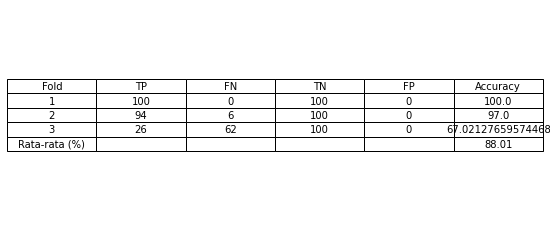

In [8]:
# Additional code to evaluate and calculate TP, FN, TN, FP for each fold
fold_results = []

for fold in range(k):
    # Load the saved model for this fold
    model = load_model(f"D:/kuliah/Tugas Akhir/Code/Klasifikasi Jenis Buah Lokal/models/K-Fold Validation/MobileNetV2-RGB_fold_{fold+1}.h5")
    
    # Predict on the test data
    test_preds = model.predict(test_generator)
    test_preds_classes = np.argmax(test_preds, axis=1)
    test_labels = test_generator.classes
    
    # Calculate confusion matrix components
    TP = np.sum((test_preds_classes == 1) & (test_labels == 1))
    TN = np.sum((test_preds_classes == 0) & (test_labels == 0))
    FP = np.sum((test_preds_classes == 1) & (test_labels == 0))
    FN = np.sum((test_preds_classes == 0) & (test_labels == 1))
    
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # Store results
    fold_results.append({
        "Fold": fold + 1,
        "TP": TP,
        "FN": FN,
        "TN": TN,
        "FP": FP,
        "Accuracy": accuracy * 100  # Convert to percentage
    })
    
    # Print results for this fold
    print(f"Fold {fold + 1} Results:")
    print(f"TP: {TP}")
    print(f"FN: {FN}")
    print(f"TN: {TN}")
    print(f"FP: {FP}")
    print(f"Accuracy: {accuracy}")
    print()

# Convert to DataFrame for easier handling
df = pd.DataFrame(fold_results)

# Calculate average accuracy
average_accuracy = df["Accuracy"].mean()

# Add the average row
df = df.append({
    "Fold": "Rata-rata (%)",
    "TP": "",
    "FN": "",
    "TN": "",
    "FP": "",
    "Accuracy": round(average_accuracy, 2)
}, ignore_index=True)

# Create the table
fig, ax = plt.subplots(figsize=(8, 4))  # Set size frame
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save as image
plt.savefig("performance_table.png", bbox_inches='tight', pad_inches=0.1)
plt.show()